# RIP.ie daily death data (v2)

* rip.ie
* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)

In [2]:
def get_data(dups=False):
    
    df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    return df

df = get_data()
df = df[df.year>=2008]

449109


## fill missing county

In [3]:
counties = ['Limerick', 'Dublin', 'Louth', 'Donegal', 'Tipperary',
       'Wicklow', 'Mayo', 'Cavan', 'Westmeath', 'Carlow', 'Leitrim',
       'Kildare', 'Kilkenny', 'Cork', 'Meath', 'Offaly', 'Wexford',
       'Roscommon', 'Galway', 'Kerry', 'Monaghan', 'Laois', 'Sligo',
       'Clare', 'Longford', 'Waterford']

def fill_county(x):    
    c=x.county
    if c not in ['',None,np.nan]:
        return c
    a = x.address.split()[-1]
    if a in counties:
        return a    
    #print(c,a)
    return ''

df.county.value_counts()
df['county']=df.apply(fill_county,1)

## remove emigrant deaths

In [4]:
cities=['England','London','Manchester','Liverpool','Leeds','Birmingham','Glasgow','Edinburgh',
        'New York','Boston','Pittsburgh','Philadelphia','Sydney','Melbourne','Perth']
search='|'.join(cities)
df = df[~df.address.str.contains(r"\b(%s)\b" %search)]
print (len(df))

<ipython-input-4-9709d3a7eda1>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df.address.str.contains(r"\b(%s)\b" %search)]


409703


## get male/female

In [5]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
male=list(pd.read_csv('male_names.csv')['name'].str.lower())
u=[]
def check_name(x):
    """try to detect sex"""
    
    notice=str(x.notice).lower()
    mr=['son of','husband of']
    for n in mr:
        if n in notice:
            return 'M'
    fr=['wife of','daughter of']
    for n in fr:
        if n in notice:
            return 'F' 
    if 'convent' in notice or 'wife of' in notice:
        return 'F'
    kwds = ['loving','home','residence','family','parents','heartbroken',
            'son','daughter','sister','brother','remains','wife','partner']
    for n in kwds:
        if 'his '+n in notice:
            return 'M'
        elif 'her '+n in notice:
            return 'F'
    name=x['name']
    if type(name) is float:
        return
    if 'née' in name:
        return 'F'
    #print (x)
    s = name.split()
    s = [i.strip("()").strip(',').lower() for i in s]
    #print (s)
    for n in s:
        if len(n)<=1:
            continue
        if n in female:
            return 'F'
        elif n in male:
            return 'M'            
    #print (s)
    u.extend(s)
    return 'U'

df['sex'] = df.apply(check_name,1)
df.sex.value_counts()

M    207789
F    200596
U      1318
Name: sex, dtype: int64

In [74]:
df[df.sex=='U'].to_csv('unknown.csv')

## nursing homes

crude method to to find notices referring to nursing homes. may take several minutes

In [7]:
nhomes = pd.read_csv('nursing_homes.csv')
search = '|'.join(nhomes.name)
ss = r"\b(%s)\b" %search
#print (ss)

def find_nhome(x):
    if type(x.notice) is not str:
        return
    notice = x.notice.replace(',',' ')
    f =  re.findall(ss,notice)
    if len(f)>0:
        return f[0][0]    
    kwds = ['nursing home','care home','residential care']
    for k in kwds:
        if k in notice.lower():
            return 'unknown'
    
import time
st=time.time()
z=df.sample(600,random_state=4)
z['home'] = z.apply(lambda x: find_nhome(x),1)
#print (x.home)
print (len(z[~z.home.isnull()]))
print(time.time()-st)

103
0.4976532459259033


In [ ]:
z[z.home=='unknown']

In [9]:
df['home'] = df.apply(lambda x: find_nhome(x),1)

In [10]:
df.to_pickle('rip_dn_scrape_final.pkl')

# Plots

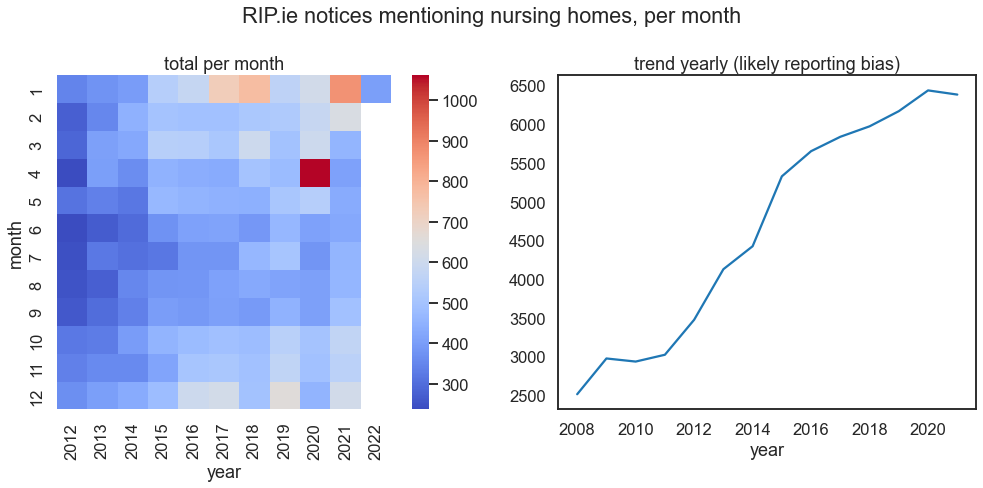

In [11]:
sub=df[~df.home.isnull()]
X=pd.pivot_table(sub, index='month',columns='year',values='home',aggfunc='size')
f,ax=plt.subplots(1,2,figsize=(14,7))
axs=ax.flat
g=sns.heatmap(X.iloc[:,4:],cmap='coolwarm',ax=axs[0]) #annot=True,annot_kws={'fontsize':8}
f.suptitle('RIP.ie notices mentioning nursing homes, per month')
axs[0].set_title('total per month')
#print (X)
sub[sub.year<2022].groupby('year').size().plot(ax=axs[1])
axs[1].set_title('trend yearly (likely reporting bias)')
plt.tight_layout()
f.savefig('nursing_home_heatmap.png')

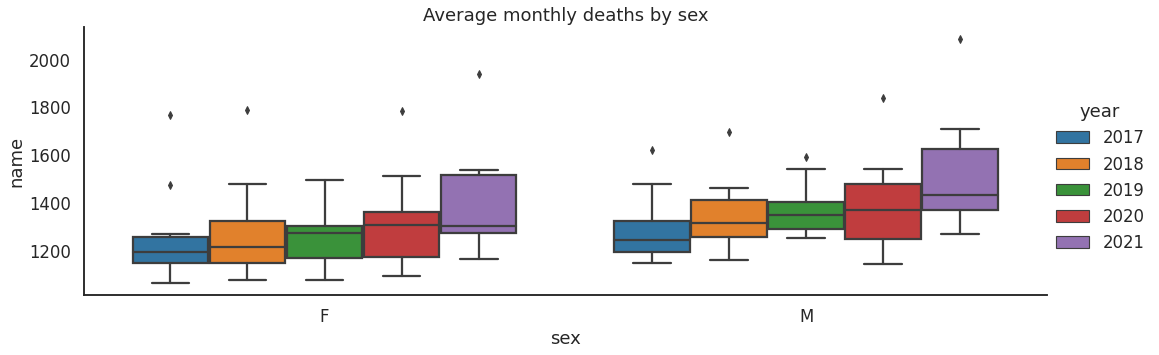

In [82]:
sub=df[df.sex!='U']
g=sub.groupby(['year','month','sex']).agg({'name':np.size}).reset_index()
g = g[(g.year>2016) & (g.year<2022)]
#print (g)
sns.catplot(data=g,x='sex',y='name',hue='year',kind='box',aspect=3.0)
plt.title('Average monthly deaths by sex')
plt.savefig('ireland_deaths_ripie_bysex.png',dpi=150)

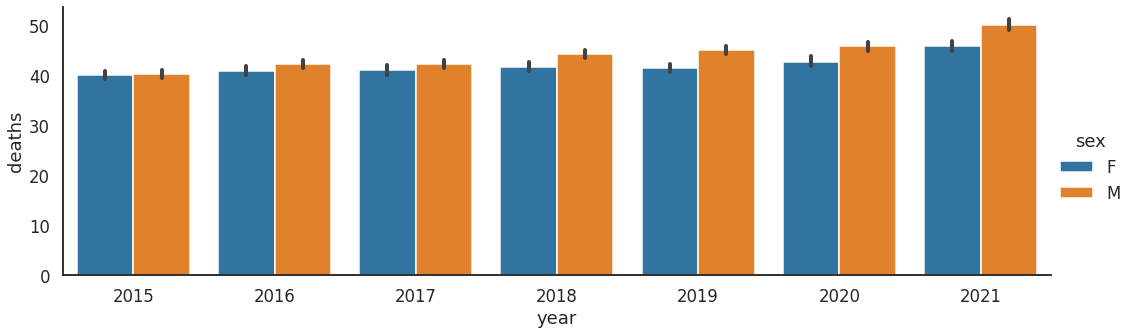

In [259]:
sub=df[df.sex!='U']
#sub=df[~df.home.isnull()]
d=pd.DataFrame(sub.groupby(['date','sex','year']).size(),columns=['deaths']).reset_index()
#d.to_csv('rip_est_deaths_daily.csv',index=False)
d = d[(d.year>2014) & (d.year<2022)]
sns.catplot(data=d,x='year',y='deaths',hue='sex',kind='bar',aspect=3.0) 

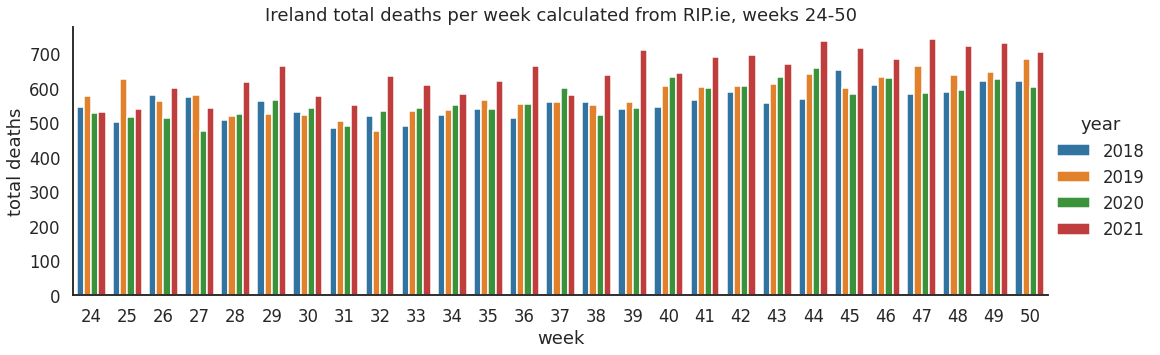

In [199]:
#sub=df[~df.home.isnull()]
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>23) & (g.week<=50)]
g = g[(g.year>2017) & (g.year<2022)]
#print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0)
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks 24-50')
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

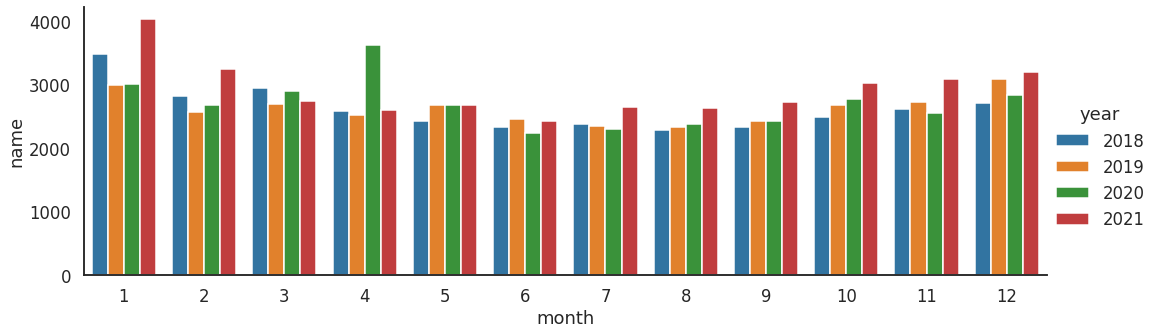

In [198]:
g=df.groupby(['year','month']).agg({'name':np.size}).reset_index()
g = g[(g.year>2017) & (g.year<2022)]
sns.catplot(data=g,x='month',y='name',hue='year',kind='bar',aspect=3.0)
plt.savefig('ireland_deaths_ripie_bymonth_v2.png',dpi=150)

In [20]:
pop = pd.read_csv('ireland_population.csv')
#wbcdrt = pd.read_csv('ireland_cdrt.csv')

In [16]:
#x=df[(df.month<=12) & (df.month>5)]
totals = df.groupby('year').agg('size')
#print (totals)
'''ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths per year')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)'''

"ax=totals.plot(kind='bar',grid=True,figsize=(10,5))\nplt.title('RIP.ie estimate, total deaths per year')\nsns.despine()\nplt.tight_layout()\nplt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)"

In [17]:
gro = pd.read_csv('gro_deaths_yearly.csv')

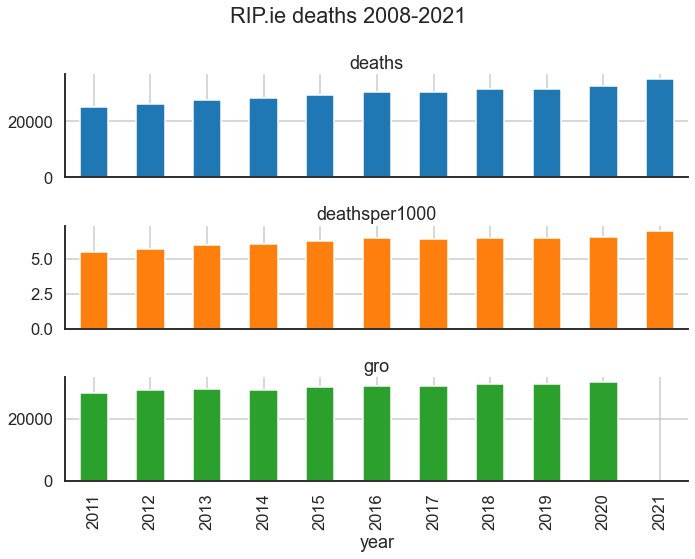

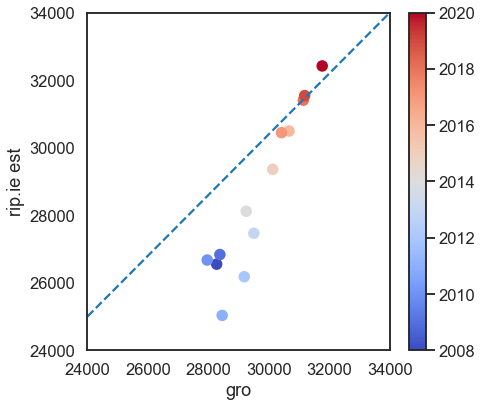

In [22]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.deaths/d['pop']*1e3
d=d.merge(gro,on='year',how='left')
d['diff'] = d.deaths-d.gro
d[3:].plot(x='year',y=['deaths','deathsper1000','gro'],kind='bar',subplots=True,grid=True,legend=False,figsize=(10,8))
plt.suptitle('RIP.ie deaths 2008-2021')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

fig,ax=plt.subplots(1,1,figsize=(7,6))
d.plot('gro','deaths',kind='scatter',c=d.year,s=100,cmap='coolwarm',ax=ax)
ax.set_ylabel('rip.ie est')
ax.plot([24000, 34000], [25000, 34000], ls='--')
ax.set_xlim(24000,34000)
ax.set_ylim(24000,34000)
plt.tight_layout()
fig.savefig('ireland_deaths_gro_vs_ripie2.png',dpi=120)

In [ ]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[23:52,13:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=20)
plt.suptitle('RIP.ie deaths per week 2021')
sns.despine()
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

In [ ]:
x = df.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=2,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for y in range(2008,2021):
    ax.vlines(pd.to_datetime('%s-12-31' %y),0,160,color='r',ls=':')

plt.suptitle('RIP.ie deaths 2013-2021, 14 day average')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend_v2.png',dpi=150)

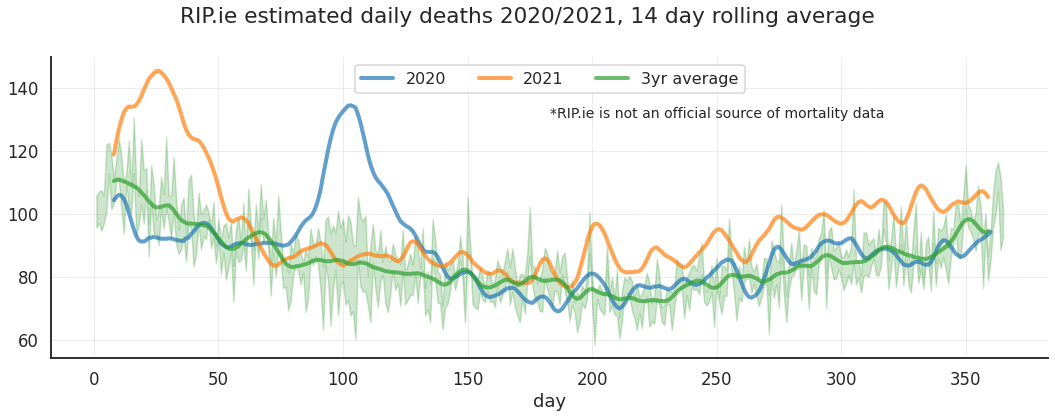

In [129]:
def plot_average_trend(df, title=''):
    byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
    #print (byday.iloc[:,9:-3])
    byday['3yr average'] = byday.iloc[:,9:-3].mean(1)
    x = byday[[2020,2021,'3yr average']]
    #x = x.loc[50:]
    #x.loc[364:,2021] = np.nan
    win=14
    meanday = x.rolling(window=win,win_type='hamming',center=True).mean()
    ax=meanday.plot(figsize=(15,6),lw=4,alpha=0.7)
    ave=x['3yr average']
    sd=byday.iloc[:,8:-3].std(1)

    ax.fill_between(ave.index, ave-(sd/2), ave+(sd/2), color='green', alpha=0.2)
    ax.grid(linestyle='--',linewidth=.5)
    plt.legend(loc=9,ncol=3,fontsize=16)
    sns.despine()
    plt.suptitle('%s, %s day rolling average' %(title,win))
    plt.tight_layout()
    plt.text(0.5,0.8,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
    
plot_average_trend(df,'RIP.ie estimated daily deaths 2020/2021')
plt.savefig('ireland_deaths_ripie_compared_mean_v2.png',dpi=150)

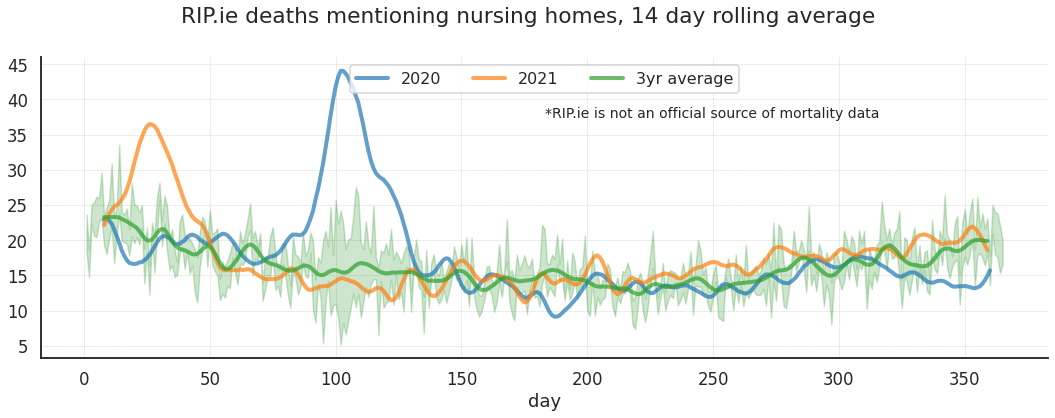

In [131]:
s=df[~df.home.isnull()]   
plot_average_trend(s,'RIP.ie deaths mentioning nursing homes')
plt.savefig('ireland_deaths_ripie_compared_mean_nursing_homes.png',dpi=150)

## GRO compare

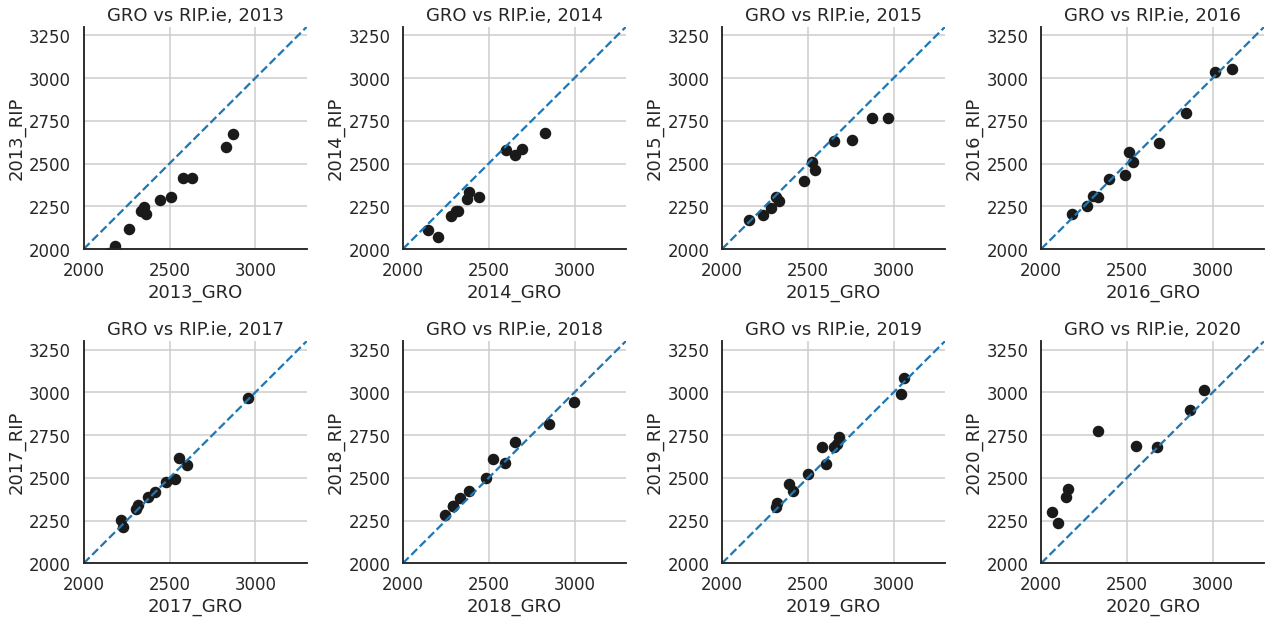

In [204]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

In [12]:
eu=pd.read_csv('estat_demo_r_mwk_ts_filtered.tsv',sep='\t').T
eu.columns=['Eurostat']

In [ ]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
#print (x[-20:])
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
#print (x[-20:])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')

## CSO RIP

CSO's estimates can be accessed via their Pxstat system [here](https://data.cso.ie/product/MFPDA). See also https://www.cso.ie/en/releasesandpublications/in/vs/informationnoteonthepublicationofmortalityfiguresusingpublicdatasources/

In [16]:
cso=pd.read_csv('RIP02.20220126T230118.csv')
cso['date'] = pd.to_datetime(cso.Day)

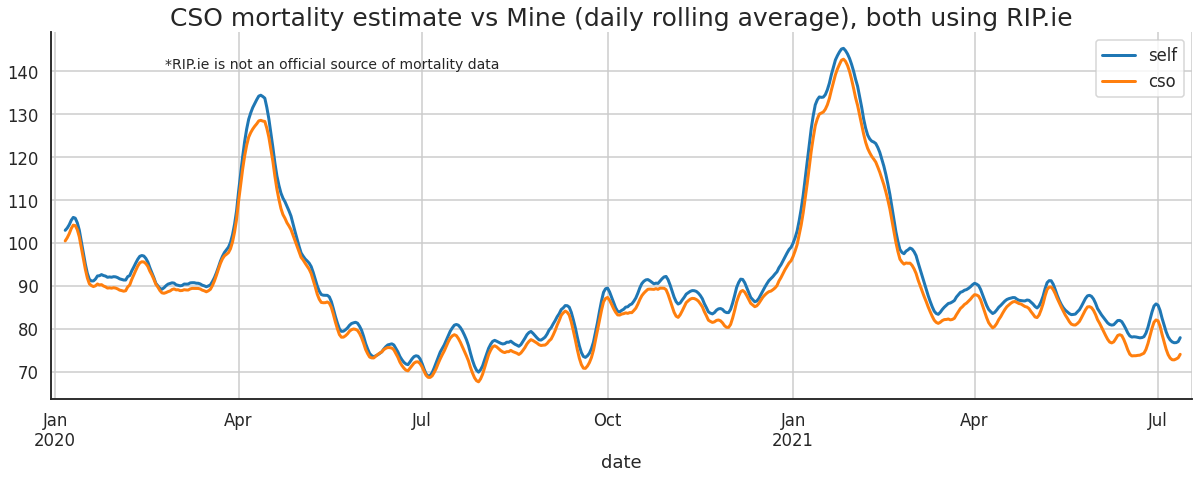

In [17]:
x = pd.DataFrame(df.groupby('date').size(),columns=['deaths']).reset_index()
x=x.merge(cso,on='date',how='right').set_index('date')
x=x[['deaths','VALUE']]
#(x.deaths-x.VALUE).rolling(window=win).mean().plot()
x.columns=['self','cso']
win=14
x=x.rolling(window=win,win_type='hamming',center=True).mean()

fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
plt.title('CSO mortality estimate vs Mine (daily rolling average), both using RIP.ie',fontsize=25)
plt.text(0.1,0.9,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig.savefig('cso_ireland_deaths_compared.png')

In [ ]:
agep=pd.read_csv('EY002.20220127T230103.csv')
agep=agep[(agep.Sex=='Both sexes') &(agep['Age Group']!='All ages')]
agep['total']=agep.groupby('CensusYear')["VALUE"].transform('sum')
agep['ratio']=agep.VALUE/agep.total
agep

In [ ]:
x=df[(df.year==2020) & (df.month==4) & (df.home.notnull())]
x.home.value_counts()

In [ ]:
x